# Using Random Forest Classifiers to detect anomalies from FinBIF specimen data

Random Forest is recommended method by many scientific papers. It only evaluates a random subset of predictors to identify the best predictors instead of searching over all predictors. 

Down-sampling (‘balanced RF') is used in this method to reduce the bias of overlapping / imbalanced classes. See https://nsojournals.onlinelibrary.wiley.com/doi/full/10.1111/ecog.05615

Use the model by selecting the taxon_id variable and run the model.

NOTE: this works only well with a few species that have been checked manually 


## 1. Environment Setup and Configuration

In [1]:
from load_data import get_occurrence_data
from dotenv import load_dotenv
import os, random, helpers, warnings
import geopandas as gpd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import RandomizedSearchCV


np.random.seed(42)
random.seed(42)

warnings.filterwarnings('ignore') # Suppress warnings for cleaner output

In [3]:

# Load environment variables
load_dotenv()
virva_access_token = os.getenv('VIRVA_ACCESS_TOKEN')
open_access_token = os.getenv('ACCESS_TOKEN')
access_email = os.getenv('ACCESS_EMAIL')

# API and data file configuration
time = '2000-01-01'
country_id = "ML.206"
selected = 'unit.unitId,unit.taxonVerbatim,unit.linkings.taxon.scientificName,unit.linkings.taxon.nameEnglish,unit.linkings.taxon.id,gathering.conversions.dayOfYearBegin'
taxon_id = 'MX.61819' # mäkikenttämittasri # Change here the taxon ID you want to use. IDs can be found from api.laji.fi taxon endpoint
coordinateAccuracyMax='200'
base_url = 'https://api.laji.fi/v0/warehouse/private-query/unit/list?'
pages = 'all'
effective_tag_absent = 'AUTO_DISTRIBUTION_CHECK,AUTO_PERIOD_CHECK' 
effective_tag_present = 'AUTO_VALIDATIONS_PASS'

# File paths
presence_points_path = f'data_obs/{taxon_id}_presence_RF.gpkg'
absence_points_path = f'data_obs/{taxon_id}_absence_RF.gpkg'
output_path = f'data_results/{taxon_id}_predicted_RF.gpkg'
sample_points_area = 'data_env/SuomenValtakunta_2024_100k.shp'
corine_path = 'data_env/corine_classified.tif'
raster_paths = ['data_env/dem.tif', 'data_env/nvdi.tif', 'data_env/rain.tif', 'data_env/temp.tif']
raster_paths_for_buffer = ['data_env/tree_vol.tif']

# Parameters for data processing
grid_size_for_duplicates = 500
corine_buffer_size = 100
checkerboard_split_grid_size = 10000

# Define feature columns for the model
feature_columns = ['x', 'y', 'Urban', 'Park', 'Rural', 'Forest', 'Open forest', 'Fjell', 'Open area', 'Wetland', 'Open bog', 'Freshwater', 'Marine', 'dem', 'nvdi', 'rain', 'temp', 'tree_vol', 'gathering.conversions.dayOfYearBegin']



# 2. Download or Load Presence and Absence Data

In [4]:

# Load or download presence data
if os.path.exists(presence_points_path): 
    print(f"Using present data from the memory...")
    presence_points = gpd.read_file(presence_points_path)
else:
    print("Downloading present data from the API...")
    data_url = f'{base_url}selected={selected}&page=1&pageSize=10000&taxonId={taxon_id}&effectiveTag={effective_tag_present}&countryId={country_id}&coordinateAccuracyMax={coordinateAccuracyMax}&time={time}/&geoJSON=true&featureType=CENTER_POINT&access_token={virva_access_token}&personEmail={access_email}' 
    presence_points = get_occurrence_data(data_url, pages=pages).to_crs(3067)
    presence_points[presence_points['unit.linkings.taxon.id'] == f'http://tun.fi/{taxon_id}'] # Select only the specific taxon if the api returned many
    presence_points.to_file(presence_points_path, driver='GPKG')

# Remove duplicates using grid size
presence_points = helpers.remove_duplicates(presence_points, grid_size_for_duplicates)
print(f"Present data processed. Number of observations: {len(presence_points)}")


Loading 1 pages..
Page 1 downloaded
grid created
In total 823 duplicates were removed with a grid size 500
Present data processed. Number of observations: 155


In [4]:
# Load or download absence data
if os.path.exists(absence_points_path): 
    print(f"Using absence data from the memory...")
    absence_points = gpd.read_file(absence_points_path)
else:
    print("Downloading absence data from the API...")
    data_url = f'{base_url}selected={selected}&page=1&pageSize=10000&taxonId={taxon_id}&effectiveTag={effective_tag_absent}&countryId={country_id}&coordinateAccuracyMax={coordinateAccuracyMax}&time={time}/&geoJSON=true&featureType=CENTER_POINT&access_token={virva_access_token}&personEmail={access_email}' 
    absence_points = get_occurrence_data(data_url, pages=pages).to_crs(3067)
    absence_points[absence_points['unit.linkings.taxon.id'] == f'http://tun.fi/{taxon_id}'] # Select only the specific taxon if the api returned many
    absence_points.to_file(absence_points_path, driver='GPKG')

# Remove duplicates using grid size
absence_points = helpers.remove_duplicates(absence_points, grid_size_for_duplicates)
print(f"Absence data processed. Number of observations: {len(absence_points)}")


Using absence data from the memory...
Absence data processed. Number of observations: 180


In [5]:
# Combine presence and absence data into a single GeoDataFrame
merged = helpers.stack_geodataframes(presence_points, absence_points, add_class_label=True)
merged.describe()

,gathering.conversions.dayOfYearBegin,class
count,1297.000000,1297.000000
mean,202.141866,0.861218
std,17.383250,0.345852
min,1.000000,0.000000
25%,192.000000,1.000000
50%,202.000000,1.000000
75%,213.000000,1.000000
max,261.000000,1.000000


# 4. Visualize Presence and Background Samples

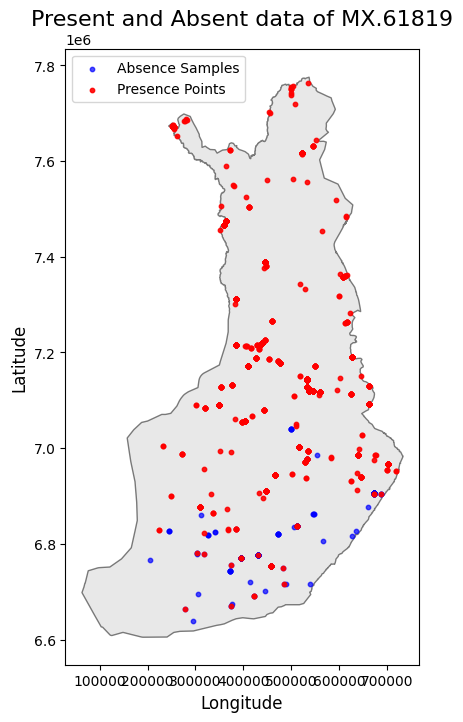

In [6]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the background polygons
borders = gpd.read_file(sample_points_area)
borders.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.5, label='Background Polygons')

# Plot the background samples
absence_points.plot(
    ax=ax,
    color='blue',
    markersize=10,
    alpha=0.7,
    label='Absence Samples'
)

# Plot the presence points
presence_points.plot(
    ax=ax,
    color='red',
    markersize=10,
    alpha=0.9,
    label='Presence Points'
)

# Add a legend
plt.legend()

# Add labels and a title for better clarity
ax.set_title(f'Present and Absent data of {taxon_id}', fontsize=16)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# Show the plot
plt.show()


# 5. Enrich Data with Environmental Features

In [7]:
# Add land cover proportions and raster values
merged = helpers.calculate_land_cover_proportions(merged, corine_path, corine_buffer_size)
merged = helpers.extract_raster_values_with_buffer(merged, raster_paths_for_buffer)
merged = helpers.extract_raster_values(merged, raster_paths)

# Extract x and y coordinates for machine learning features
merged['x'] = merged.geometry.x
merged['y'] = merged.geometry.y

print(f"\nAfter enrichment and dropping points outside of the raster extents, the dataset has {len(merged)} samples.")

print(merged.describe())

Calculating corine land cover proportions...
Processing raster: data_env/tree_vol.tif with buffer of 100 meters
Processing raster: data_env/dem.tif
Processing raster: data_env/nvdi.tif
Processing raster: data_env/rain.tif
Processing raster: data_env/temp.tif

After enrichment and dropping points outside of the raster extents, the dataset has 1297 samples.
       gathering.conversions.dayOfYearBegin        class        Urban  \
count                           1297.000000  1297.000000  1297.000000   
mean                             202.141866     0.861218     0.338611   
std                               17.383250     0.345852     0.289997   
min                                1.000000     0.000000     0.000000   
25%                              192.000000     1.000000     0.051948   
50%                              202.000000     1.000000     0.265823   
75%                              213.000000     1.000000     0.540541   
max                              261.000000     1.000000  

# 6. Split Data into Training and Testing Sets

In [8]:
# Split back to the train and tast datasets using checkerboard split to reduce spatial autocorrelation
train_points, test_points = helpers.checkerboard_split(merged, 10000) # Note: this may not be the best way to divide data into training and testing sets but difficult to find better options

In [9]:

# Assign spatial weights to account for over-represented areas sampling bias
train_points['sample_weights'] = helpers.distance_weights(train_points)
test_points['sample_weights'] = helpers.distance_weights(test_points)

# Normalize feature columns
train_points[feature_columns] = helpers.normalise_columns(train_points[feature_columns]) # Normalise present data
test_points[feature_columns] = helpers.normalise_columns(test_points[feature_columns]) # Normalise absent data

In [10]:

# Prepare feature matrices and target variables
X_train = train_points[feature_columns]
y_train = train_points['class']
sample_weights_train = train_points['sample_weights']

X_test = test_points[feature_columns]
y_test = test_points['class']
sample_weights_test = test_points['sample_weights']


<Axes: >

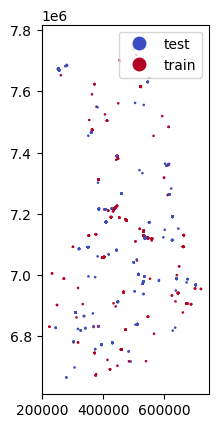

In [11]:
# we'll re-merge them for plotting purposes
train_points['split'] = 'train'
test_points['split'] = 'test'
checker = helpers.stack_geodataframes(train_points, test_points)
checker.plot(column='split', markersize=0.75, legend=True, cmap='coolwarm')

# 7. Find best parameters for Random Forest Model

In [12]:
rf = RandomForestClassifier(class_weight="balanced_subsample")

param_grid = {
    'n_estimators': [50, 100, 200, 300],         # Number of trees in the forest
    'max_depth': [10, 20, 30, None],             # Maximum depth of trees (None means fully grown trees)
    'min_samples_split': [2, 5, 10],         # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4, 8],            # The minimum number of samples required to be at a leaf node.
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

rf_random = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=50, cv=3, scoring='roc_auc', n_jobs=-1)
rf_random.fit(X_train, y_train, sample_weight=sample_weights_train)
print(f"Best parameters: {rf_random.best_params_}")

Best parameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}


# 8. Train Random Forest Model

In [13]:
# Initialize with the best parameters from RandomizedSearchCV
best_rf_model = RandomForestClassifier(**rf_random.best_params_, class_weight="balanced_subsample")

# Fit the model with the training data and sample weights
best_rf_model.fit(X_train, y_train, sample_weight=sample_weights_train)

rf_predictions = best_rf_model.predict(X_test)
rf_probs = best_rf_model.predict_proba(X_test)[:, 1]

# 9. Print and Visualize Prediction Probabilities

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.80      0.72        71
           1       0.97      0.94      0.96       521

    accuracy                           0.92       592
   macro avg       0.81      0.87      0.84       592
weighted avg       0.93      0.92      0.93       592

Accuracy: 0.92
ROC AUC: 0.96
TSS: 0.74


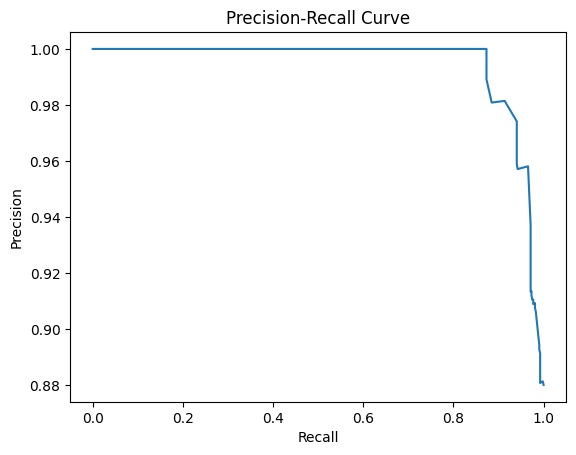

In [14]:
tss = helpers.get_tss(y_test, rf_predictions)

print("Random Forest Classification Report:")
print(classification_report(y_test, rf_predictions))
print(f"Accuracy: {accuracy_score(y_test, rf_predictions):.2f}")
print(f"ROC AUC: {roc_auc_score(y_test, rf_probs):.2f}") # ROC AUC = Receiver Operating Characteristic Area Under the Curve. AUC is a well-known metric in SDM. It measures discrimination – i.e. the ability of the model to discriminate presences from absences
print(f"TSS: {tss:.2f}")

helpers.plot_precision_recal_curve(y_test, rf_probs)

                                 Feature    Importance
1                                      y  3.484181e-01
16                                  temp  2.110511e-01
15                                  rain  1.950045e-01
13                                   dem  9.807676e-02
17                              tree_vol  2.942085e-02
0                                      x  2.781784e-02
2                                  Urban  2.090012e-02
14                                  nvdi  2.050456e-02
5                                 Forest  1.294579e-02
6                            Open forest  1.195961e-02
18  gathering.conversions.dayOfYearBegin  9.301330e-03
3                                   Park  7.552277e-03
4                                  Rural  6.117391e-03
11                            Freshwater  9.298082e-04
8                              Open area  1.745214e-17
12                                Marine  0.000000e+00
10                              Open bog  0.000000e+00
7         

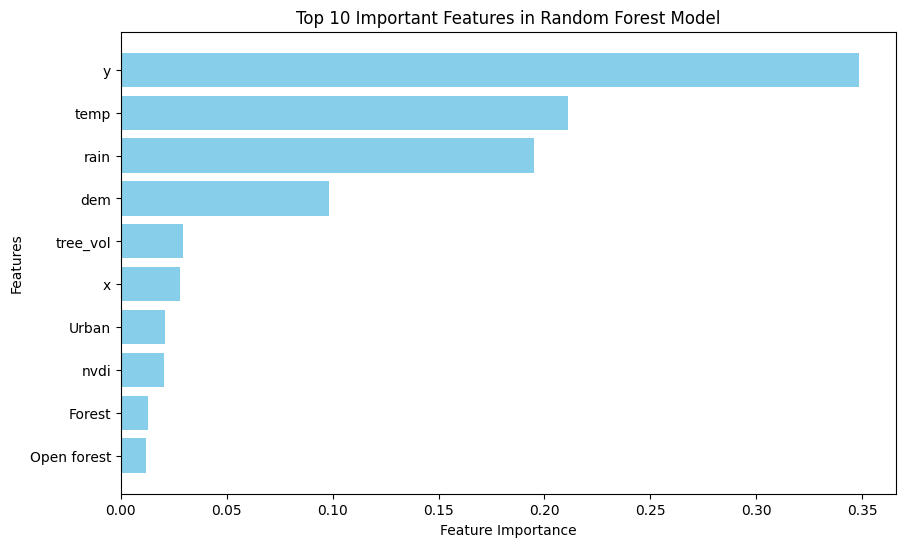

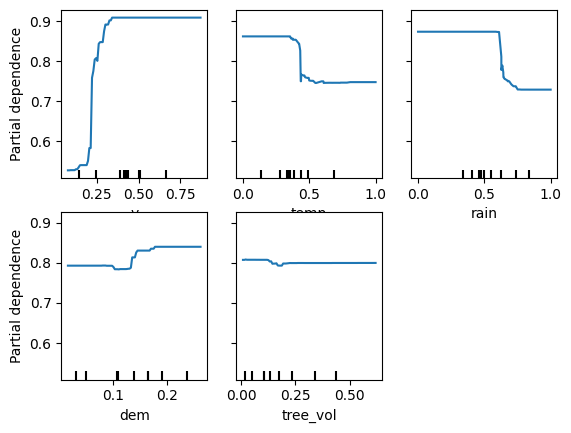

In [15]:

top5_feature_indexes = helpers.visualise_feature_importances(best_rf_model, feature_columns)

PartialDependenceDisplay.from_estimator(
    estimator=best_rf_model,             # Trained model
    X=X_train,                           # Training data
    features=top5_feature_indexes,       # Indices or names of features to plot (adjust this to relevant features)
    feature_names=feature_columns,       # Feature names for labeling the plot
    kind='average',                      # Type of partial dependence ('average' or 'individual')
    subsample=1000,                      # Subsample for faster computation (optional, useful for large datasets)
    random_state=42                      # Ensures reproducibility
)

# Display the plot
plt.show()



In [16]:
# Extract real presence points
real_presence_points = test_points[test_points['class'] == 1]

# Add predictions and probabilities to real presence points
real_presence_points['rf_prediction'] = rf_predictions[test_points['class'] == 1]
real_presence_points['rf_probability'] = rf_probs[test_points['class'] == 1]

# Normalize probabilities for visualization
real_presence_points['rf_probability_normalized'] = helpers.normalise_columns(real_presence_points[['rf_probability']])

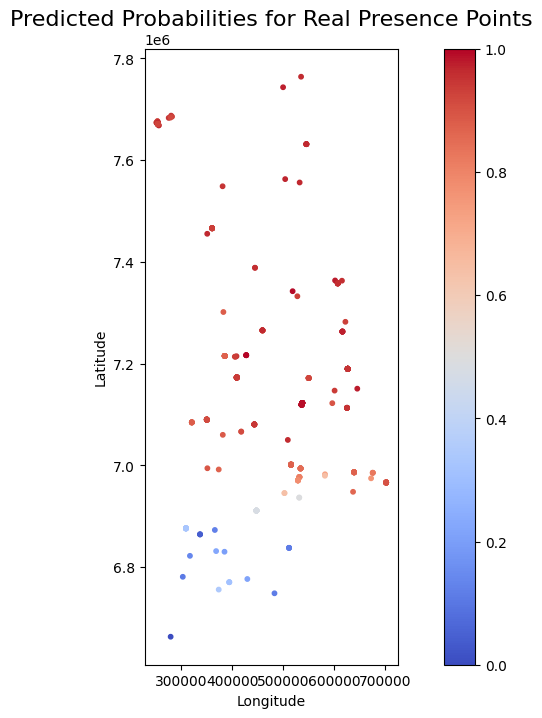

In [17]:
# Create a map visualization
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plot real presence points with probabilities
real_presence_points.plot(
    column='rf_probability_normalized',
    cmap='coolwarm',
    legend=True,
    markersize=10,  # Adjust size as needed
    ax=ax
)

# Add titles and labels
ax.set_title('Predicted Probabilities for Real Presence Points', fontsize=16)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()


In [18]:
# Export to GPKG
real_presence_points.to_file(output_path, driver='GPKG')